### Intel Image Classification Using CNN 

# Overview
CNN is very familiar algorithm to classify an image according to the class of the image. CNN consists of neurons that have some weight, bias and activation functions as Multilayer Perceptron (NN in general), but we will get to know a new term called convolution layer. The dataset we used was an Intel Image Classification dataset that we got from Kaggle. This dataset is a landscape image data worldwide. The dataset consists of 25000 images measuring 150x150 pixels and it divided into 6 classes, as follows:

0 : Buildings
1 : Forest
2 : Glacier
3 : Mountain
4 : Sea
5 : Street

In [1]:
!pip install kaggle

In [1]:
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
pip install google.colab

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import ZipFile
file_name = "/content/intel-image-classification.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Packages
To be able to do classification using neural networks, here we need several packages from Python. Besides pandas and numpy, another important packages are Keras and scikit-learn which will help us build NN architecture and do classification calculations.

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D

# Data Preparation
The goal of data preparation is to prepare data that tidy and ready to be applied in NN models. The data preparation stage is divided into 3, i.e:

*   Data Transformation
*   Data Augmentation
*   Data Generator

# Data Transformation
In the initial stages of data preparation, We will transform image data into a multidimensional matrix. This matrix will read and convert images into a matrix with pixel length, pixel width, and color channel sizes. Here, we will read a dataset consisting of data train, data validation, and data test / prediction.

In [7]:
seg_train = '/content/seg_train/seg_train'
seg_test = '/content/seg_test/seg_test'
seg_pred = '/content/seg_pred/seg_pred'

# Data Augmentation
After data transformation, the next step is data augmentation. Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalize. When we work with image data there are cases where we've lack training dataset. Augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above).

In [8]:
generate = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Data Generator
In the previous process, we actually didn't add data to the dataset we have. Keras ImageDataGenerator class actually works by:

*   Accepting a batch of images used for training.
*   Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.)
*   Replacing the original batch with the new, randomly transformed batch
*   Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training

In [9]:
training_set = generate.flow_from_directory(seg_train,
                                            target_size = (100, 100),
                                            batch_size = 14034,
                                            classes = ["buildings","forest","glacier","mountain","sea","street"],
                                            class_mode = 'categorical')
test_set = generate.flow_from_directory(seg_test,
                                        target_size = (100, 100),
                                        batch_size = 3000,
                                        classes = ["buildings","forest","glacier","mountain","sea","street"],
                                        class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Splitting Data Train and Data Test
Splitting dataset here aims to select training data and test data that will be used for the training process and the model evaluation process. The next() function here returns the next item in an iterator.

In [10]:
X_train,y_train = training_set.next()
X_test,y_test = test_set.next()

# Architecture Model
Mainly our model architecture consist 4 different layers:

*   convolutional layers
*   pooling layers (for downsampling features)
*   dense layers (for output classifier)
*   dropout (prevent model overfitting)

# Build Model

The architecture can be seen in the picture below:

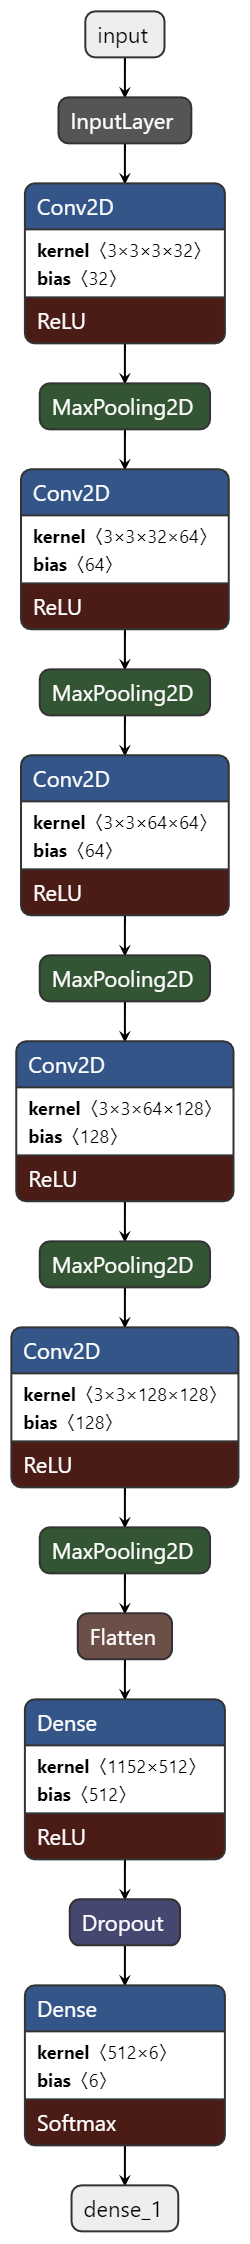

In [11]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(100,100,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(64,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))
model.add(Conv2D(128,(3,3), activation='relu' , padding= "same"))
model.add(MaxPool2D(pool_size=(2,2),strides=None))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(6,activation ='softmax'))

## Model Compiler
Next, we choose our model lost function and optimzer in order to do backpropagation. We use categorical crossentropy as cost function because our domain problem is multiclass classification and we use adam optimizer.

In [12]:
model.compile(optimizer="adam", loss= "categorical_crossentropy", metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       7

## Phase of Training Data
After building the CNN model, in the previous stage we have selected some data to be trained using the CNN model. In this phase, the CNN model is trained to recognize each input image with 100 epoches.

In [14]:
Model = model.fit(X_train, y_train, epochs = 15, verbose=1, batch_size=500, validation_split = 0.1)

Epoch 1/15
26/26 [==============================] - 27s 260ms/step - loss: 1.5935 - accuracy: 0.3306 - val_loss: 1.1297 - val_accuracy: 0.5477
Epoch 2/15
26/26 [==============================] - 4s 172ms/step - loss: 1.0821 - accuracy: 0.5769 - val_loss: 0.9687 - val_accuracy: 0.6182
Epoch 3/15
26/26 [==============================] - 4s 171ms/step - loss: 0.9646 - accuracy: 0.6232 - val_loss: 0.8346 - val_accuracy: 0.6866
Epoch 4/15
26/26 [==============================] - 4s 173ms/step - loss: 0.8787 - accuracy: 0.6599 - val_loss: 0.8411 - val_accuracy: 0.6759
Epoch 5/15
26/26 [==============================] - 4s 171ms/step - loss: 0.8315 - accuracy: 0.6872 - val_loss: 0.7170 - val_accuracy: 0.7443
Epoch 6/15
26/26 [==============================] - 4s 173ms/step - loss: 0.7561 - accuracy: 0.7248 - val_loss: 0.7402 - val_accuracy: 0.7144
Epoch 7/15
26/26 [==============================] - 5s 180ms/step - loss: 0.7019 - accuracy: 0.7405 - val_loss: 0.6572 - val_accuracy: 0.7642
Epoch

In the train phase, the model produces a training accuracy of around 83.64% and Validation Accuracy of 80.63% with a loss of around 0.46. These results indicate that accuracy is quite good

## Model Evaluation
At this stage we try to evaluate the CNN model with new data. Pre-selected test data is used to test how the CNN model classifies intel images according to their respective classes.

In [15]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

94/94 [==============================] - 1s 7ms/step - loss: 0.5390 - accuracy: 0.8070
Test loss: 0.5389719009399414
Test accuracy: 0.8069999814033508


After evaluating the model with 3000 test data, the accuracy is 80.7%, the value is below the accuracy results in the training phase with a loss value of 0.53 where this value is greater than the results in the training phase. From these results we can conclude that there are differences that are not far enough, that means our model is not indicated by overfitting. To see the results of the evaluation more clearly, you can see the model evaluation chart.

## Evaluation Plot

In [16]:
for key in Model.history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


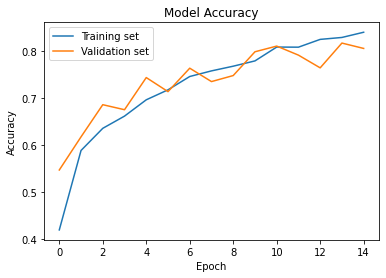

In [17]:
plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

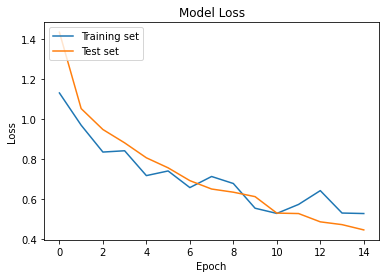

In [18]:
plt.plot(Model.history['val_loss'])
plt.plot(Model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

## Save the Model

In [19]:
model.save("model.h5")

In [20]:
from keras.models import load_model

In [21]:
model = load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       7